part1：对google网址上的任何non-tarrif measures数据爬取的一般规则

#Ⅰ：选定google网站作为爬取引擎，选定目标的网站作为新闻的来源（例如CNN，BBC，Reuters等）

#Ⅱ：选定目标网站的新闻的网址，例如CNN的新闻网址为："https://edition.cnn.com/world"，在google里面采用指定的搜索方式确定搜索目标，例如 site:cnn.com "non-tarrif"(确定搜索时对"且"和"或"的编译)

#III：确定搜索时url的构成，query参数与start参数在页面中的调整，关键词表需要自己尝试得到，或者利用其他方法调整，时间限制采用参数"before"和"after"确定范围.

#IV: 从request对象中获取text文本，并将其构成一个列表，包含着四个columns，分别为abstract,date,url和title，其中有date的返回格式有若干个"几天后","几年后"。尤其需要注意的是要在url里定义搜索语言为英文（代理ip在世界各地游荡），确保时间格式可以解析；另外需要确定一下location参数确保返回的东西不会在世界各地搜索出不同的结果（这个目前看来不能确定）

*author:Jinming(main crawler analyzer),Chongrui

*2022/9/18

若通过其他方式访问：

cuhk materials: https://libguides.lib.cuhk.edu.hk/current_issues/e-news

南华早报(可以无限制访问)；factiva Dow Jones(报纸基础信息的汇总，有华尔街日报，华盛顿邮报，路透社等等部分信息，但没有financial times)；

In [1]:
from distutils.log import info
import requests
from lxml import etree
import pandas as pd
import numpy as np
import time
import os
import re
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
from fake_useragent import UserAgent

os.chdir("C:\\Users\\Justin\\Dropbox\\google_crawler\\crawler_google\\new_google_tariff\\")


In [5]:
ua = UserAgent() #随机化user agent

In [6]:
ua.random

'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2117.157 Safari/537.36'

- 翻页部分会出现以下情况：start=0作为参数时，可能出现class为MjjYud的情况（也可能没有），因此可能翻页（也可能不翻页）
- 2022/9/22 error 403

In [7]:
class GoogleNews:
    def __init__(self, keyword_1, match_kw, web='ft.com', after="2018-01-01", before="2021-01-01", whether_fuzzy_search=0, page_max=200000): #更改时间范围参数和页面大小参数
        self.web = web
        # https%3A%2F%2Fwww.ft.com  financial time (not free)
        # bbc.com   BBC
        # scmp.com  南华早报，南华早报cuhk订阅了api可以无限制访问资源，已确认南华早报的内容直接写在网页上
        self.after = 'after%3A' + after
        self.before = 'before%3A' + before
        self.keyword_1 = keyword_1  #keyword不一定在abstract或title里，可能在正文里
        self.match_kw = match_kw
        self.page_max = page_max
        self.whether_fuzzy_search = whether_fuzzy_search

        self._suffix_3 = 'start='
        self._add = "&"
        #确定必须使用英文来搜索以免返回格式出现问题
        self._lr = "hl=en"
        self._plus = "+"
        self._profix = 'https://www.google.com.hk/search?q=site%3A'
        self._header = {'user-agent': ua.random}
        # self.url_pattern = re.compile(r'q=(.*)&sa=') ,header当然也可以进行替换，有不同的use_agent，看看自己的电脑
        self.url_pattern = re.compile(r'^http')
        self.month_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Sep', 'Oct', 'Nov', 'Dec']
        # ~表示模糊匹配策略，搭配起来可以做site：bbc.com "non_tarrif" "trade war" ~action_word
        self.count_parse_error = 0

    def _construct_url(self, max_page):
        self.search = self._profix + self.web + self._plus  + self.keyword_1 + self._plus + self.before + self._plus + self.after + self._add + self._lr + self._add + self._add + self._suffix_3 + max_page

    def proxy_geturl(self, max_req=5):
        payload = {'api_key': '714e53772cc7c3fb8b9186b885ac9bea', 'url': self.search, 'keep_headers': 'true'} #api需要及时续费，可获得动态ip进行访问
        count_error = 0
        while True:
            try:
                rsp = requests.get('http://api.scraperapi.com', params=payload, headers=self._header)
                # rsp.encoding = 'utf-8'
                # print(rsp.status_code)
                if rsp.status_code != 200:
                    count_error += 1
                    if count_error > 5:
                        break
                    continue
                else:
                    rsp.encoding = 'utf-8'
                    return rsp.text
            except:
                print('Proxy error! Change proxy.')
                count_error += 1
                if count_error > 5:
                    break
                continue
        try:
            print("Trying the ip of the current server...")
            rsp = requests.get(self.search, headers=self._header)
            rsp.close()
            rsp.encoding = 'utf-8'
            return rsp.text
        except:
            print("All the proxies are not available!")
            return ""

    def div_get(self, max_page):
        self._construct_url(max_page)
        request_body = self.proxy_geturl(self.search)
        try:
            tree = etree.HTML(request_body)
        except:
            self.count_parse_error += 1
            return None
        self.div_section = tree.xpath('//div[@class="MjjYud"]') #从固定的某个class下面去逐层寻找,广告和图片的class与此不同
        return 0 if len(self.div_section) == 0 else 1
    
    def page_turn(self):
        data_to_be_loaded = []
        for i in range(0, self.page_max, 10):
            div_len = self.div_get(str(i))
            if div_len == 0 or div_len is None:  #判断是不是搜索到底部了，如果是就会返回毫无内容的div_section
                break
            else:
                for j in self.div_section:
                    if self.whether_fuzzy_search == 1:
                        aw = GoogleNews.em_parse(j, self.match_kw)
                    else:
                        aw = ''
                       # if tmp == 0:
                        #    continue
                    url_res = ''
                    url = GoogleNews.url_parse(j)
                    for k in url:
                        tmp = self.url_pattern.search(k)
                        try:
                            http_start = tmp.span()[0]
                            if http_start == 0:
                                url_res = k
                        except AttributeError:
                            continue
                    title = GoogleNews.title_parse(j)
                    time_, abstract = self.time_judge(j)
                    if time_ == '' or url_res == '' or len(url) == 0 or len(title) == 0:
                        #如果时间或url都没有被抓到，或者title以及url的长度为0，抓别的东西时可以调整要不要有时间的
                        continue
                    else:
                        data_to_be_loaded.append((url[-1], title[-1], time_[-1], abstract, 'non tariff' if self.whether_fuzzy_search == 1 else 'tariff', aw))
                    #这里返回的都是列表,取最后一个元素
        return data_to_be_loaded
    
    @staticmethod
    def csv_loader(pd_dataFrame, web, date_, action=''):
        df = pd.DataFrame(pd_dataFrame, columns=['url', 'title', 'time', 'abstract', 'strategy_type', 'aw'])
        df = df.drop_duplicates()  #遍历上述所有的关键词，并把按他们搜索的结果放到一起来,目前每个关键词搜索到两百条为止
        df = df[~df['url'].str.contains('video')] #去掉视频链接

        df['web'] = web
        df['action'] = action[1:] if action != '' else action
        df = df.drop_duplicates(subset=["title", "action"]) #若有重复或转载的链接
        df.to_csv(f'./{date_}', mode='a', header=False, index=False)

    @staticmethod   #为所有的抓取函数选定静态方法
    def url_parse(div_element):
        return div_element.xpath('.//a/@href')

    @staticmethod
    def title_parse(div_element):
        return div_element.xpath('.//h3/text()')

    @staticmethod
    def em_parse(div_element, match_keywords):
        em_lower_list = [i.lower() for i in div_element.xpath('.//em/text()')]
        for i in em_lower_list:
            count = 0
            for j in match_keywords:
                count += i.find(j)
            if count == -len(match_keywords):
                return 1
        return 0                       

    @staticmethod
    def abstract_parse(span_m, time_block, index):
        '''
        span_m -> list, time_judge中的m
        time_block -> str, time_format
        index -> int, time_judge中的count_t
        '''
        # print((span_m, time_block, index))
        if time_block == '':  #没有时间的摘要，我们都不要
            return ''
        else:
            try:
                if span_m[index+1] == ' — ': #只要有时间，span里面有时间的分隔符-，抓取其之后的所有内容
                    return ''.join(span_m[index+2:])
                else:
                   return ''
            except IndexError:
                return ''
        
    def time_judge(self, div_element):  #搜索div_section下每一行数据内有没有正则表达式可以识别出来的时间
        time_block = []
        m = list(div_element.xpath('.//span/text()'))
        count = 0
        count_t = -1
        whether_break = 0
        for i in m:
            count_t += 1
            if re.search(r'\d+ days ago',i):
                set = re.findall(r'\d+',i)
                gap = int(set[0])
                date = datetime.datetime.now() - datetime.timedelta(days=gap)
                date = date.strftime('%Y-%m-%d')
                time_block.append(date)
                count += 1
                whether_break = 1
            elif re.search(r'\d+ months ago',i):
                set = re.findall(r'\d+',i)
                gap = int(set[0])*30
                date = datetime.datetime.now() - datetime.timedelta(days=gap)
                date = date.strftime('%Y-%m-%d')
                time_block.append(date)
                count += 1
                whether_break = 1
            elif re.search(r'\d+ minutes ago',i):
                date = datetime.datetime.now().strftime('%Y-%m-%d')
                time_block.append(date)
                count += 1
                whether_break = 1
            elif re.search(r'\d+ hours ago',i):
                date = datetime.datetime.now().strftime('%Y-%m-%d')
                time_block.append(date)
                count += 1
                whether_break = 1
            else:
                for j in self.month_short:
                    i = i.replace("Sept","Sep")  #让四位简写可以归一化
                    i = i.replace("June","Jun")
                    i = i.replace("July","Jul")
                    i = i.replace("Octo","Oct")
                    i = i.replace("Augu","Aug")
                    i = i.replace("Nove","Nov")
                    i = i.replace("Dece","Dec")
                    if re.search(j,i):
                        try:
                            time_format=datetime.datetime.strptime(i,'%d %b %Y')
                            date = datetime.datetime.strftime(time_format,'%Y-%m-%d')
                            time_block.append(date)
                            count += 1
                            whether_break = 1
                            break #一旦日期格式解析成功，先行跳出小循环
                        except:
                            try:
                                time_format=datetime.datetime.strptime(i,'%b %d, %Y')
                                date = datetime.datetime.strftime(time_format,'%Y-%m-%d')
                                time_block.append(date)
                                count += 1
                                whether_break = 1
                                break
                            except:
                                try:
                                    time_format=datetime.datetime.strptime(i,'%Y-%m-%d')
                                    date = datetime.datetime.strftime(time_format,'%Y-%m-%d')
                                    time_block.append(date)
                                    count += 1
                                    whether_break = 1
                                    break
                                except:
                                    try:
                                        time_format=datetime.datetime.strptime(i,'%d-%b-%Y')
                                        date = datetime.datetime.strftime(time_format,'%Y-%m-%d')
                                        time_block.append(date)
                                        count += 1
                                        whether_break = 1
                                        break 
                                    except:
                                        print(i)
                        else:
                            pass
            if whether_break == 1:  #任何一处都要跳出循环
                break
        if count == 0:
            time_block.append('')
        
        abstract = GoogleNews.abstract_parse(m, time_block, count_t)
        
        return time_block, abstract

In [8]:
# 2015-01-01 -- 2021-01-01
year_list = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
month_list = ['01', '04', '07', '10']
day_list = ['01']
web = ['ft.com' , 'bbc.com', 'scmp.com', 'cnn.com', 'cnbc.com', 'wsj.com', 'bloomberg.com', 'reuters.com',
'nytimes.com', 'thehill.com', 'politico.com', 'huffingtonpost.com', 'theatlantic.com', 'theintercept.com',
'vox.com', 'foxnews.com', 'slate.com', 'nbcnews.com', 'abcnews.go.com', 'msnbc.com', 'npr.org', 'apnews.com',
'latimes.com', 'washingtonpost.com', 'time.com', 'newsweek.com', 'theguardian.com', 'independent.co.uk',
'telegraph.co.uk', 'dailymail.co.uk', 'thetimes.co.uk', 'express.co.uk', 'mirror.co.uk', 'standard.co.uk', 
'economist.com', 'usnews.com', 'nikkei.com', 'forbes.com', 'thestreet.com', 'finance.yahoo.com', 'fortune.com']
action_word = ["red-tape", "inspection", "delay", "retaliatory", "ban",
"prohibit", "threatens", "restrictions", "regulatory","license","quarantine", "quotas", "sanctions", "dumping",
"remedy", "discrimination", "fees", "spoiled","rotting","scrutiny","reviews","subsidy"]
action_word = ['~'+item for item in action_word]
keyword_non_tariff = '"trade war"+"china"+ "non-tariff"'
keyword_tariff = '"trade+war"+"china"+"tariff"'

In [9]:
time_point = ['-'.join([year, month, day]) for year in year_list for month in month_list for day in day_list if year != '2021'] + ['2021-01-01']

In [10]:
for i in range(len(time_point)-1):
    count_parse_error = 0
    start_date = time_point[i]
    end_date = time_point[i+1]
    print(f'{start_date}__{end_date}...')
    for web_name in web:
        for keyword in [keyword_non_tariff, keyword_tariff]:
            if keyword == keyword_non_tariff:
                for action_ in action_word:
                    keyword_tariff_list = ['trade war', 'china', 'tariff']
                    google_news = GoogleNews('+'.join([keyword, action_]), web=web_name, after=start_date, before=end_date, match_kw=keyword_tariff_list, whether_fuzzy_search=1)
                    data = google_news.page_turn()
                    count_parse_error += google_news.count_parse_error
                    # print(f'{web_name}: {google_news.search}')
                    google_news.csv_loader(data, web_name, f'{start_date}__{end_date}.csv', action=action_)
            else:
                google_news = GoogleNews(keyword, web=web_name, after=start_date, before=end_date, match_kw=None)
                data = google_news.page_turn()
                count_parse_error += google_news.count_parse_error
                # print(f'{web_name}: {google_news.search}')
                google_news.csv_loader(data, web_name, f'{start_date}__{end_date}.csv')
    print(f'{start_date}_{end_date}: {count_parse_error} parse error.')
                

2015-01-01__2015-04-01...
2015-01-01_2015-04-01: 0 parse error.
2015-04-01__2015-07-01...
2015-04-01_2015-07-01: 1 parse error.
2015-07-01__2015-10-01...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the current server...
Trying the ip of the curren

#Part 2

#1) 遍历并比照2014.01.01-2017.12.31日间的新闻搜索条目，检查其与2018.01.01-2021.01.01之间的新闻搜索条目是否显著增加对于“non-tarrif”等关键词的返回频率（备注:使用“主流媒体搜索”与“全体搜索”两个方案，“主流媒体搜索”给出一个“主流媒体清单”，“非主流媒体搜索”时需要注意“转载是否被纳入频次计算”？若不需要则对title进行duplicates drop；“非主流媒体搜索”可能返回很多条目，那么对关键词的严格约束将成为必要的)

A: 只要主流媒体，但仍然要防止大面积转载，按标题来处理，tariff 与 non-tariff都需要

#2) 比照HS 2-digit下属的多种具体类产品，例如oil seeds - soybean, 并对这些具体的产品建立list, 搜索这些产品的报导的条目数量是否与Trade War中的import share成正比(备注：搜索时间区间与其他关键词是否有另外的要求？)

A: 把总量和per share的两个变量都表示出来就行

主流新闻与财经网站(共计40个): 

| 网址 | 中文名称 |
| --- | --- |
| ft.com | financial time 金融时报 |
|  bbc.com | BBC  |
| scmp.com | 南华早报 |
|  cnn.com | CNN |
|  cnbc.com | 美国全国广播公司 |
|  wsj.com | 华尔街日报 |
| bloomberg.com | 彭博社 |
|reuters.com | 路透社 |
| nytimes.com | 纽约时报 |
| thehill.com | 国会山日报|
| politico.com | 政治新闻报|
| huffingtonpost.com |赫芬顿邮报|
| theatlantic.com | 大西洋月刊 |
| theintercept.com | 拦截者|
| vox.com | 沃克斯新闻网(左翼新闻) |
| foxnews.com | 福克斯新闻网 |
| slate.com | 石板新闻 |
| nbcnews.com | NBC 新闻 |
| abcnews.go.com | ABC 新闻 |
| msnbc.com | MSNBC |
| npr.org | 全国公共广播电台 |
| apnews.com | 美联社 |
| latimes.com  | 洛杉矶时报 |
| washingtonpost.com | 华盛顿邮报 |
| time.com | 时代周刊 |
| newsweek.com | 新闻周刊 |
| theguardian.com | 卫报 |
| independent.co.uk | 独立报|
| telegraph.co.uk | 每日电讯报 |
| dailymail.co.uk |每日邮报 |
| thetimes.co.uk | 泰晤士报|
| express.co.uk | 每日快报 |
| mirror.co.uk | 镜报 |
| standard.co.uk | 伦敦标准晚报 |
| economist.com | 经济学人 |
| usnews.com | 美国新闻 |
| nikkei.com | 日经新闻(Asia) |
| forbes.com | 福布斯新闻 |
| thestreet.com | thestreet 金融资讯网 |
|finance.yahoo.com | 雅虎财经 |
| fortune.com | 财富杂志|

Non-tariff Measures Table:
|Methods	|Tools	| Directions of regulation|
| --- | --- | --- |
|Quantitative | quotas|	This provides a guarantee that imports do not exceed a certain amount, since foreign competitors lose the opportunity to expand sales in the market by lowering prices. Quotas are a more flexible and convenient policy tool that makes foreign trade policy more selective.|
|		|licensing requirements|	Secures the rights and obligations of the parties to the relationship. This process takes place based on profitability averaging and takes into account the needs of society, strict regulation.|
|		|quarantine | Introduced in order to contain the spread of the pandemic.|
|		|voluntary public restrictions | They are used as a result of political pressure from countries that import oil. They are introduced to minimize the threat of tough trade protection measures.|
|Hidden	| state procurements | They create significant trade barriers by discriminating against foreign suppliers. Developing countries are deprived of the opportunity to use this tool.|
| |technical barriers|Its application concerns administrative procedures, details of the current market, and corporate structure. The reasons for the appearance are not discriminatory considerations but a connection with the need to unify production needs.|
|  |taxes and fees| The introduction of taxes and fees on imported goods in the consumer market will lead to an increase in import prices regardless of cost.| This fact allows one to consider this subgroup as discriminatory domestic taxation.|
|Financial|subsidies|State aid as an economic incentive to expand exports. Thus, goods in the domestic market are sold at a higher price than in the foreign market.|
| |dumping|It may be the result of a country's foreign trade policy. Otherwise, it can be caused by typical monopoly behavior - price discrimination: when an export company with a monopoly in the domestic market maximizes its income due to inelastic demand and rising prices|
| |sanctions|For example, a trade embargo, when a country prohibits the import or export of goods from a country|



搜索策略
``` python
keyword = "trade war" + "china" + "non tariff"/"tariff"(action_word)

action_word = ["red tape","inspection","delay","retaliatory",
              "strict regulatory","ban","prohibit" ,"reject",
              "threatens","restrictions","license requirements","quarantine","quotas",
              "sanctions","dumping","remedy",
              "discrimination"]
```

构建url过程中遍历对象包括：

1. 关键词keyword（针对关键词Non-tariff使用action word以或的逻辑拼接做约束，tariff则不做限制）

2. 主流媒体网站

3. 按季度区分的发布时间
   
4. edit:仅仅使用non-tarrif而不使用action word做第一步，时间的长度将不再分块输出，解析等内容也应当修正

返回所有的按季度区分的搜索结果，设置两个dummy，一个是来源网站，一个是搜索出现的关键词

Table A

Q2: 找到在HS 2-digit下面的所有内容的4位编码级的物品的单词类型,搜索规则:采用"china"+"trade war"+(大类名词或主要产品品名的fuzzy match,若范围太大了则采用“识别词”)搜索

识别词的选择原则：<font color="#dd0000">“常见而且能够很好cover组内事物在新闻里的一般表述，但不会与其他组造成混淆”</font><br />

1:找到的篇目首先要进行组内去重,这样可以保证组内的篇目没有重复(但如果article A同时提及了a,b两种产品，则两者的篇目数量都各自计算)

2:若要全篇目去重，可以画占比的图并记录不同文章所包含的类别总数

Table B

Get Table A join Table B
come from:
          
          https://www.taricsupport.com/nomenclature/en/4400000000.html (check website)

          https://www.valuepenguin.com/top-exports-china-state (state check,products indentified words covered most of them)

|   | US Share of Imports | ∆ Tariff |∆ Non-Tariff Barriers| Products |
| --- | --- | --- | --- | --- |
|*Agriculture*|  -   |   -|  -   | - |
| --- | --- | ---  |  ---  | --- |
|Oil seeds, oleaginous fruits 12 | 9.11 % | 0.145 | 1.006|soybean;colza;sunflower;flax;peanuts;rapeseed;palm;shea;coconuts;olives;white sesame|
|Pulp of wood, recovered paper| 2.47 % | 0.176 | 0.247|paper;pulp;wood fiber|
|Wood and articles of wood 44 |1.73 %| 0.149 |0.105|log;wood;charcoal;lumber|
|Cereals |0.99 % |0.250| 1.492| cereal;grain;corn;rice;wheat;sorghum|
|Cotton |0.77 % |0.250 |-0.204| cotton |
|Meat and edible meat offal| 0.60 % |0.533 |-0.127| meat;pork;beef;poultry;chicken|
|Fish and crustaceans| 0.58 %| 0.282| -0.083|fish;seafood;lobster;crab|
|Raw hides and skins and leather |0.56 % |0.030 |0.004|leather;skins;raw hides|
|Rubber and articles thereof| 0.39 % |0.119 |0.370|rubber|
|Fruit and nuts| 0.38 % |0.428| -0.392|cherry;apple;orange;berry;walnut;almond;pistachio;nut;fruit|
|Food industries, residues and wastes thereof| 0.30 % |0.139| 0.688|  |
|Dairy produce, birds’ eggs| 0.25 %| 0.201 |0.309|    |
|Miscellaneous edible preparations| 0.23 %| 0.063| -0.188 |   |
|Preparations of vegetables| 0.16% |0.115 |0.089|    |
|Beverages, spirits and vinegar| 0.07% |0.283 |-0.108|    |
|Preparations of cereals |0.06 %| 0.156 |-0.193|    |
|Sugars and sugar confectionery| 0.05 % |0.100 |-0.102|    |
|Animal or vegetable fats, oils| 0.04 % |0.166 |-0.027|    |
|Vegetables and certain roots and tubers| 0.03 % |0.199 |0.223|    |
|Wool, fine or coarse animal hair| 0.01 % |0.188 |0.136|   |
|*Manufacturing*| - |  -| - |   - |
| --- |  ---  | ---  | ---  |  --- |
|Electrical machinery and parts| 1.52 %| 0.063| -0.191|electrical; electronics|
|Nuclear reactors and machinery| 1.43 % |0.070| -0.080|nuclear|
|Vehicles and parts and accessories thereof| 1.39 % |0.002 |0.366|vehicle;car|
|Aircraft, spacecraft and parts thereof| 1.05 % |0.001 |0.186|aircraft;spacecraft|
|Optical instruments |1.02 %| 0.073 |-0.269|diodes,optical,spectrometer|
|Plastics and articles thereof| 0.62 %| 0.098| -0.059|plastics|
|Pharmaceutical products| 0.32 %| 0.007 |-0.048|medical;vaccines;syringes|
|Organic chemicals| 0.30 %| 0.101 |0.091|chemicals|
|Chemical products n.e.c. |0.27 %| 0.030 |-0.172|    |
|Copper and articles thereof| 0.13 % |0.233| -0.102|    |
|Iron or steel articles |0.11 %| 0.137 |-0.111|     |
|Aluminium and articles thereof| 0.10 %| 0.371 |-0.221|    |
|Inorganic chemicals| 0.08 % |0.099 |0.328|    |
|Glass and glassware |0.07 % |0.093 |-0.250|    |
|Essential oils and resinoids| 0.07 %| 0.182 |-0.712|     |
|Natural, cultured pearls| 0.04 % |0.134 |-0.159|     |
|Salt, sulphur, earths| 0.03 % |0.130 |-0.133|     |
|Iron and steel| 0.03 % |0.130 |-0.072|    | 
|Ores, slag and ash |0.02 % |0.097| 1.106|     |
|Cotton |0.01 % |0.187 |0.894|   |

``` python
fuzzy_word = ["soybean","colza","sunflower","flax","peanuts","rapeseed","palm","shea","coconuts","olives","white sesame",
             "paper","pulp","wood fiber","log","wood","charcoal","lumber","cereal","grain","corn","rice","wheat","sorghum",
             "cotton","meat","pork","beef","poultry","chicken","fish","seafood","lobster","crab","leather","skins","raw hides",
             "rubber","cherry","apple","orange","berry","walnut","almond","pistachio","nut","fruit","electrical","electronics",
             "nuclear","vehicle","car","aircraft","spacecraft","diodes","optical","spectrometer","plastics","medical",
             "vaccines","syringes","chemicals"]
```
https://www.globaltrademag.com/global-trade-daily/
https://www.chinadaily.com.cn/a/201906/26/WS5d12a5baa3103dbf1432a34e.html



In [156]:
df = pd.read_csv('2015-01-01__2021-01-01.csv',names = ['url','title','time','abstract','category','web'],encoding = 'ISO-8859-1')
df.head(10)


,url,title,time,abstract,category,web
0,https://www.ft.com/content/2635fa64-f6d7-11e8-...,US-China trade war: truce shows who holds the ...,2018/12/3,A truce has been struck in the US- but the ter...,non-tariff,ft.com
1,https://www.ft.com/chinese-trade?page=97,Chinese trade | Financial Times,2018/6/19,readies weapons in US trade spat ... World's...,non-tariff,ft.com
2,https://www.ft.com/content/26f071e6-f6f5-11e8-...,US-China trade ceasefire is welcome but fragile,2018/12/3,... cybertheft of commercial secrets and barr...,non-tariff,ft.com
3,https://www.ft.com/content/740c34e4-47c1-11e8-...,Donald Trump is right: China must play by the ...,2018/4/25,average import tariffs are around double thos...,non-tariff,ft.com
4,https://www.ft.com/content/e2916586-8048-11e9-...,China paid record $22bn in corporate subsidies...,2019/5/27,paid record $22bn in corporate subsidies in 2...,non-tariff,ft.com
5,https://www.ft.com/content/ba0aa2c4-6bf6-11e8-...,Angry Trump torpedoes G7's hard-won trade harmony,2018/6/10,"... would âstrive to reduce tariff barriers,...",non-tariff,ft.com
6,https://www.ft.com/content/b41cbe94-49f8-11e8-...,Yale professor appointed chief economist at Wo...,2018/4/27,... the World Bank's response to the rising th...,non-tariff,ft.com
7,https://www.ft.com/content/4b566c36-0521-11e9-...,Economists predict the UK economy's trajectory...,2019/1/2,Trade will also be affected as both parties le...,non-tariff,ft.com
8,https://ig.ft.com/us-china-tariffs/,What's at stake in US-China trade war,2018/7/19,and the US have embarked upon a full-scale a...,tariff,ft.com
9,https://www.ft.com/content/e79ada1a-76ae-11e9-...,US consumers start to pay price of trade war w...,2019/5/15,US consumers start to pay price of with ... ...,tariff,ft.com


In [157]:
#统计以non-tariff与tariff搜索出来不同网站的个数(由于non-tarrif中多有包含tariff，故此处的tariff文章中计数将不再包含non-tariff)，并清理了少部分网站
pd.crosstab(df.web,df.category,margins=True)
#南华早报的报道明显多于其他网站

category,non-tariff,tariff,All
web,,,
abcnews.go.com,3,46,49
apnews.com,0,42,42
bbc.com,9,138,147
bloomberg.com,5,220,225
cnbc.com,11,226,237
cnn.com,4,167,171
dailymail.co.uk,2,81,83
economist.com,8,98,106
express.co.uk,0,31,31


In [166]:
#cancel the df['time']= ""
df = df.dropna(axis=0, how='any', subset=["time"])
#change the time to string
df['time'] = df['time'].astype(str)
df['month'] = df['time'].str[5:7].str.replace('/','')
#删除month == ev的观测
df = df[df['month'] != 'ev']
df = df[df['month'] != 'hi']
df = df[df['month'] != 's ']
df = df[df['month'] != 'he']


df['year']=df['time'].str[0:4].str.replace('/','')

df['y_m'] = df['year'] + '-' + df['month']
df['y_m'] = pd.to_datetime(df['y_m'])
#df['month']=df['time'].apply(lambda x:x.split('-')[1])
#df['day']=df['time'].apply(lambda x:x.split('-'))
#df['year']=df['time'].dt.strftime('%Y')
#df['a']=df['time'].dt.strftime('%Y-%m')
#let 1-3 month be 1, 4-6 month be 2, 7-9 month be 3, 10-12 month be 4
df['quarter']=df['month'].apply(lambda x:1 if int(x)<=3 else 2 if int(x)<=6 else 3 if int(x)<=9 else 4)
#df['season'] = df['year'].astype(str) + '-' + df['quarter'].astype(str)
#生成一列mark，如果year=2015且quarter=1，则mark=0，如果year=2015且quarter=2，则mark=0.25，以此类推
df['Post'] = df['year'].astype(int) + (df['quarter'].astype(int)-1)/4
df.head(10)

,url,title,time,abstract,category,web,month,year,quarter,Post,y_m
0,https://www.ft.com/content/2635fa64-f6d7-11e8-...,US-China trade war: truce shows who holds the ...,2018/12/3,A truce has been struck in the US- but the ter...,non-tariff,ft.com,12,2018,4,2018.75,2018-12-01
1,https://www.ft.com/chinese-trade?page=97,Chinese trade | Financial Times,2018/6/19,readies weapons in US trade spat ... World's...,non-tariff,ft.com,6,2018,2,2018.25,2018-06-01
2,https://www.ft.com/content/26f071e6-f6f5-11e8-...,US-China trade ceasefire is welcome but fragile,2018/12/3,... cybertheft of commercial secrets and barr...,non-tariff,ft.com,12,2018,4,2018.75,2018-12-01
3,https://www.ft.com/content/740c34e4-47c1-11e8-...,Donald Trump is right: China must play by the ...,2018/4/25,average import tariffs are around double thos...,non-tariff,ft.com,4,2018,2,2018.25,2018-04-01
4,https://www.ft.com/content/e2916586-8048-11e9-...,China paid record $22bn in corporate subsidies...,2019/5/27,paid record $22bn in corporate subsidies in 2...,non-tariff,ft.com,5,2019,2,2019.25,2019-05-01
5,https://www.ft.com/content/ba0aa2c4-6bf6-11e8-...,Angry Trump torpedoes G7's hard-won trade harmony,2018/6/10,"... would âstrive to reduce tariff barriers,...",non-tariff,ft.com,6,2018,2,2018.25,2018-06-01
6,https://www.ft.com/content/b41cbe94-49f8-11e8-...,Yale professor appointed chief economist at Wo...,2018/4/27,... the World Bank's response to the rising th...,non-tariff,ft.com,4,2018,2,2018.25,2018-04-01
7,https://www.ft.com/content/4b566c36-0521-11e9-...,Economists predict the UK economy's trajectory...,2019/1/2,Trade will also be affected as both parties le...,non-tariff,ft.com,1,2019,1,2019.00,2019-01-01
8,https://ig.ft.com/us-china-tariffs/,What's at stake in US-China trade war,2018/7/19,and the US have embarked upon a full-scale a...,tariff,ft.com,7,2018,3,2018.50,2018-07-01
9,https://www.ft.com/content/e79ada1a-76ae-11e9-...,US consumers start to pay price of trade war w...,2019/5/15,US consumers start to pay price of with ... ...,tariff,ft.com,5,2019,2,2019.25,2019-05-01


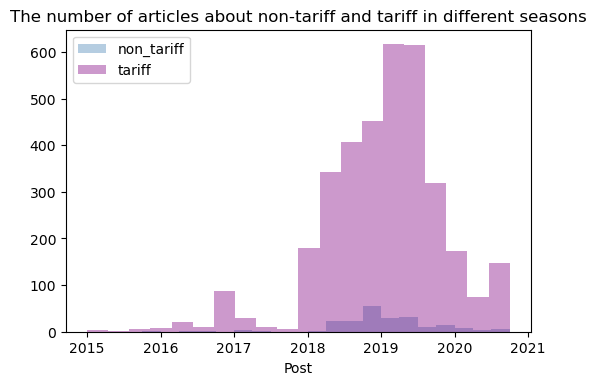

In [163]:
non_tariff =df.Post[df.category=="non-tariff"]
tariff =df.Post[df.category=="tariff"]
plt.figure(dpi=100)
sns.distplot(non_tariff,bins=20,kde=False,hist_kws={"color":"steelblue"},label="non_tariff")
sns.distplot(tariff,bins=20,kde=False,hist_kws={"color":"purple"},label="tariff")
#g.set_xticklabels(['0','a','b','c','d','e'])
plt.title("The number of articles about non-tariff and tariff in different seasons")
plt.legend()
plt.show()

vscode上传markdown图片最好上git或者网络复制地址来粘贴
<img src="https://user-images.githubusercontent.com/82168423/192295412-cc4a1cdf-b44a-496e-a340-3938962abd77.png"  alt="ImageFile" style="width: 800px;" align="left"/>

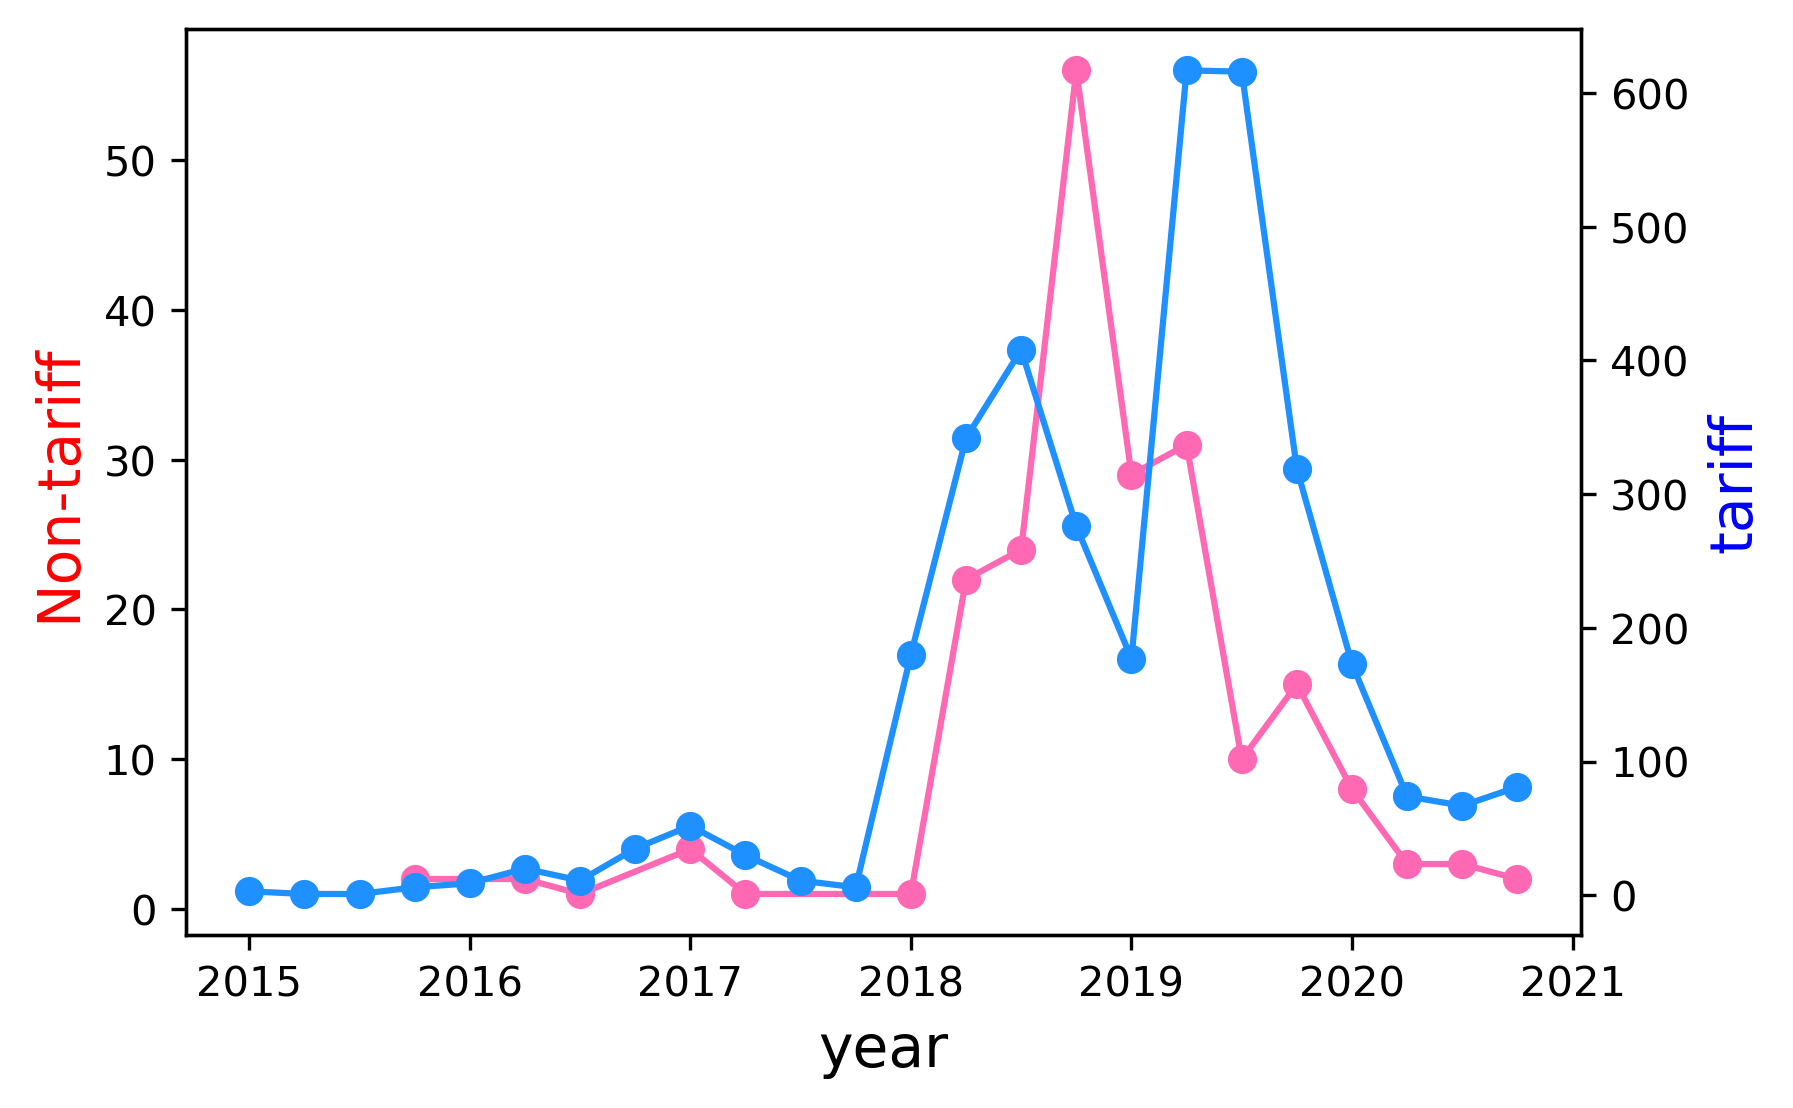

In [191]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(dpi=300)
# make a plot
ax.plot(non_tariff.value_counts().sort_index(),label="non-tariff",
        color="hotpink", 
        marker="o")
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Non-tariff",
              color="red",
              fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(tariff.value_counts().sort_index(),label="tariff",
         color="dodgerblue",marker="o")
ax2.set_ylabel("tariff",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=300,
            bbox_inches='tight')

#出口量与其新闻报道量趋势相反，符合直觉

Q2: Deal with the data from different groups, and calculate the percentage of the distribution and shares

导入利用fuzzy_match进行的工作



In [2]:
df = pd.read_csv('test.csv',names = ['url','title','time','abstract','category','word','web'],encoding = 'ISO-8859-1')
df.head(10)

,url,title,time,abstract,category,word,web
0,https://www.ft.com/content/77959222-4226-11e8-...,China makes trade concession to US by opening ...,2018/4/17,makes trade concession to US by opening indu...,kwm-fs,"trade war,china,tariff,car",ft.com
1,https://www.ft.com/content/b003947c-d97b-11e9-...,Donald Trump's trade war puts car seat maker i...,2019/9/19,As Donald Trump launched his with in early 2...,kwm-fs,"trade war,china,tariff,car",ft.com
2,https://www.ft.com/content/8d49e068-91a0-11e8-...,Car industry braces for trade war 'tsunami' - ...,2018/7/27,The chill wind of a is blowing across the in...,kwm-fs,"trade war,china,tariff,car",ft.com
3,https://www.ft.com/content/3ffc8536-bcb1-11e8-...,Toyota finds a silver lining in trade war cris...,2018/9/25,As the escalating global clouds the outlook f...,kwm-fs,"trade war,china,tariff,car",ft.com
4,https://www.ft.com/content/5a9a71d0-38c9-11e8-...,German manufacturers fear fallout from US-Chin...,2018/4/5,German manufacturers fear fallout from US- ......,kwm-fs,"trade war,china,tariff,car",ft.com
5,https://www.ft.com/content/35ccfce0-7629-11e8-...,Trump threatens 20% tariff on EU car imports -...,2018/6/22,Trump threatens 20% on EU imports ... to iss...,kwm-fs,"trade war,china,tariff,car",ft.com
6,https://www.ft.com/content/35ccfce0-7629-11e8-...,Trump threatens 20% tariff on EU car imports -...,2018/6/22,Trump threatens 20% on EU imports ... to iss...,kwm-fs,"trade war,china,tariff,car",ft.com
7,https://www.ft.com/content/812104b6-f5b3-11e8-...,Trump and Xi face hurdles in trade talks after...,2018/12/2,¡° has agreed to reduce and remove tariffs on ...,kwm-fs,"trade war,china,tariff,car",ft.com
8,https://www.ft.com/content/4f6580dc-ff53-11e9-...,US considers dropping some tariffs on China - ...,2019/11/5,The macroeconomic impact of the war with sho...,kwm-fs,"trade war,china,tariff,car",ft.com
9,https://www.ft.com/content/8993913e-399f-11e8-...,US-China trade dispute | Financial Times,2018/4/6,What's at stake in US-: the full list ¡¤ Explo...,kwm-fs,"trade war,china,tariff,car",ft.com


In [11]:
#找出word中最后一个逗号分隔的词，其为fuzzy_word
df['fuzzy_word'] = df['word'].apply(lambda x:x.split(',')[-1])
#将hs2中的分类全部标注为HS2的大类,loc函数条件替换
df.loc[(df['fuzzy_word'] == "soybean")| (df['fuzzy_word'] =="colza")|(df['fuzzy_word'] =="sunflower")|(df['fuzzy_word'] =="flax")|(df['fuzzy_word'] == "peanuts")|(df['fuzzy_word'] =="rapeseed")| (df['fuzzy_word'] =="palm")|(df['fuzzy_word'] == "shea")|(df['fuzzy_word'] == "coconuts")|(df['fuzzy_word'] =="olives")|(df['fuzzy_word'] =="white sesame"),'hs2'] = "Oil seeds, oleaginous fruits"
df.loc[(df['fuzzy_word'] == "paper")| (df['fuzzy_word'] =="pulp")|(df['fuzzy_word'] =="wood fiber"),'hs2'] = "Pulp of wood, recovered pape"
df.loc[(df['fuzzy_word'] == "log")| (df['fuzzy_word'] =="wood")|(df['fuzzy_word'] =="charcoal")|(df['fuzzy_word'] =="lumber"),'hs2'] = "Wood and articles of wood"
df.loc[(df['fuzzy_word'] == "cereal")| (df['fuzzy_word'] =="grain")|(df['fuzzy_word'] =="corn")|(df['fuzzy_word'] =="rice")|(df['fuzzy_word'] =="wheat")|(df['fuzzy_word'] =="sorghum"),'hs2'] = 'Meat and edible meat offal'
df.loc[(df['fuzzy_word'] == "meat")| (df['fuzzy_word'] =="pork")|(df['fuzzy_word'] =="beef")|(df['fuzzy_word'] =="poultry")|(df['fuzzy_word'] =="chicken"),'hs2'] = 'Meat and edible meat offal'
df.loc[(df['fuzzy_word'] == "cotton"),'hs2'] = 'Cotton'
df.loc[(df['fuzzy_word'] == "fish")|(df['fuzzy_word'] =="seafood")|(df['fuzzy_word'] =="lobster")|(df['fuzzy_word'] =="crab"),'hs2'] = 'Fish and crustaceans'
df.loc[(df['fuzzy_word'] =="leather")|(df['fuzzy_word'] =="skins")|(df['fuzzy_word'] =="raw hides"),'hs2'] = 'Raw hides and skins and leather'
df.loc[(df['fuzzy_word'] == "rubber"),'hs2'] = 'Rubber and articles thereof'
df.loc[(df['fuzzy_word'] =="cherry")|(df['fuzzy_word'] =="apple")|(df['fuzzy_word'] =="orange")|(df['fuzzy_word'] =="berry")|(df['fuzzy_word'] =="walnut")|(df['fuzzy_word'] =="almond")|(df['fuzzy_word'] =="pistachio")|(df['fuzzy_word'] =="nut")|(df['fuzzy_word'] =="fruit"),'hs2'] = 'Fruit and nuts'
df.loc[(df['fuzzy_word'] =="electrical")|(df['fuzzy_word'] =="electronics"),'hs2'] = 'Electrical machinery and parts'
df.loc[(df['fuzzy_word'] =="nuclear"),'hs2'] = 'Nuclear reactors and machinery'
df.loc[(df['fuzzy_word'] =="vehicle")|(df['fuzzy_word'] =="car"),'hs2'] = 'Vehicles and parts and accessories thereof'
df.loc[(df['fuzzy_word'] =="aircraft")|(df['fuzzy_word'] =="spacecraft"),'hs2'] = 'Aircraft, spacecraft and parts thereof'
df.loc[(df['fuzzy_word'] =="diodes")|(df['fuzzy_word'] =="optical")|(df['fuzzy_word'] =="spectrometer"),'hs2'] = 'Optical instruments'
df.loc[(df['fuzzy_word'] =="plastics"),'hs2'] = 'Plastics and articles thereof'
df.loc[(df['fuzzy_word'] =="medical")|(df['fuzzy_word'] =="vaccines")|(df['fuzzy_word'] =="syringes"),'hs2'] = 'Pharmaceutical products'


#生成时间变量
df = df.dropna(axis=0, how='any', subset=["time"])
#change the time to string
df['time'] = df['time'].astype(str)
df['month'] = df['time'].str[5:7].str.replace('/','')
df['year']=df['time'].str[0:4].str.replace('/','')
df['y_m'] = df['year'] + '-' + df['month']
df['y_m'] = pd.to_datetime(df['y_m'])
df['quarter']=df['month'].apply(lambda x:1 if int(x)<=3 else 2 if int(x)<=6 else 3 if int(x)<=9 else 4)
df['Post'] = df['year'].astype(int) + (df['quarter'].astype(int)-1)/4

df.head(10)

,url,title,time,abstract,category,word,web,fuzzy_word,hs2,month,year,y_m,quarter,Post
0,https://www.ft.com/content/77959222-4226-11e8-...,China makes trade concession to US by opening ...,2018/4/17,makes trade concession to US by opening indu...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,4,2018,2018-04-01,2,2018.25
1,https://www.ft.com/content/b003947c-d97b-11e9-...,Donald Trump's trade war puts car seat maker i...,2019/9/19,As Donald Trump launched his with in early 2...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,9,2019,2019-09-01,3,2019.50
2,https://www.ft.com/content/8d49e068-91a0-11e8-...,Car industry braces for trade war 'tsunami' - ...,2018/7/27,The chill wind of a is blowing across the in...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,7,2018,2018-07-01,3,2018.50
3,https://www.ft.com/content/3ffc8536-bcb1-11e8-...,Toyota finds a silver lining in trade war cris...,2018/9/25,As the escalating global clouds the outlook f...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,9,2018,2018-09-01,3,2018.50
4,https://www.ft.com/content/5a9a71d0-38c9-11e8-...,German manufacturers fear fallout from US-Chin...,2018/4/5,German manufacturers fear fallout from US- ......,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,4,2018,2018-04-01,2,2018.25
5,https://www.ft.com/content/35ccfce0-7629-11e8-...,Trump threatens 20% tariff on EU car imports -...,2018/6/22,Trump threatens 20% on EU imports ... to iss...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,6,2018,2018-06-01,2,2018.25
6,https://www.ft.com/content/35ccfce0-7629-11e8-...,Trump threatens 20% tariff on EU car imports -...,2018/6/22,Trump threatens 20% on EU imports ... to iss...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,6,2018,2018-06-01,2,2018.25
7,https://www.ft.com/content/812104b6-f5b3-11e8-...,Trump and Xi face hurdles in trade talks after...,2018/12/2,¡° has agreed to reduce and remove tariffs on ...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,12,2018,2018-12-01,4,2018.75
8,https://www.ft.com/content/4f6580dc-ff53-11e9-...,US considers dropping some tariffs on China - ...,2019/11/5,The macroeconomic impact of the war with sho...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,11,2019,2019-11-01,4,2019.75
9,https://www.ft.com/content/8993913e-399f-11e8-...,US-China trade dispute | Financial Times,2018/4/6,What's at stake in US-: the full list ¡¤ Explo...,kwm-fs,"trade war,china,tariff,car",ft.com,car,Vehicles and parts and accessories thereof,4,2018,2018-04-01,2,2018.25


对新闻报道结果的汇总性统计，采用了fuzzy match的词汇匹配结果,但记住这里没有“non-tariff”等措施的限定！

In [12]:
pd.crosstab(df.year,df.hs2,margins=True)
#查看每一类hs2的数量
#df['hs2'].value_counts()

hs2,"Oil seeds, oleaginous fruits",Vehicles and parts and accessories thereof,All
year,,,
2016,1,1,2
2017,0,1,1
2018,1,55,56
2019,3,43,46
2020,0,5,5
All,5,105,110


c:\Users\Justin\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<AxesSubplot:xlabel='Post'>

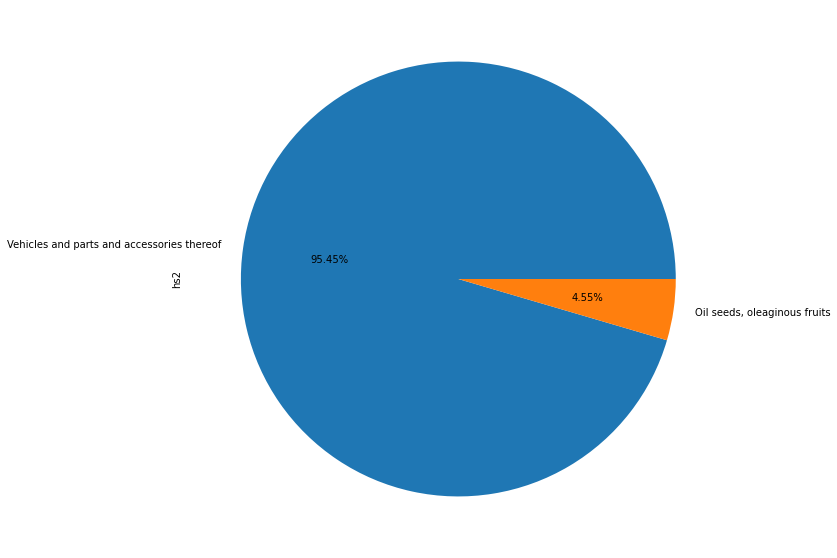

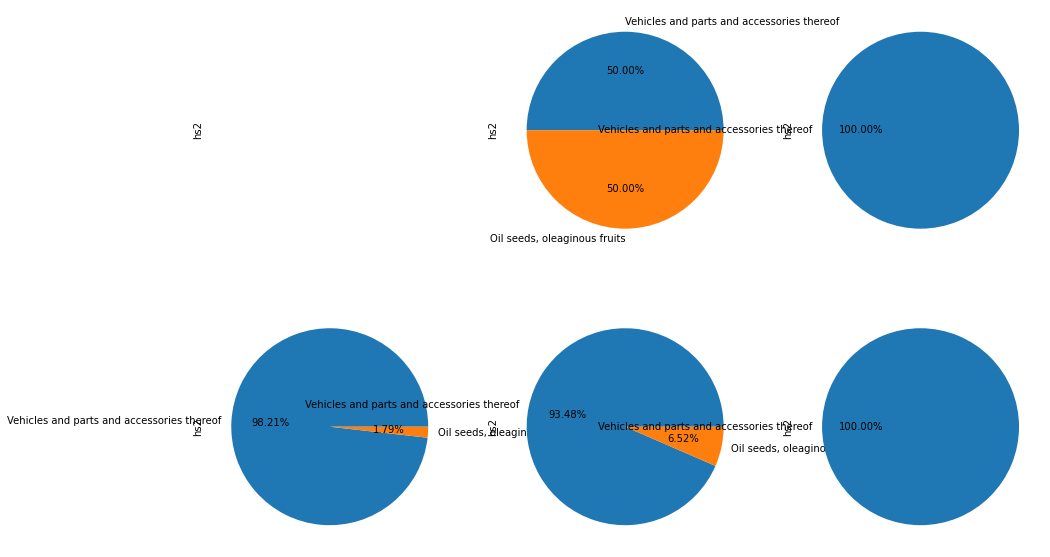

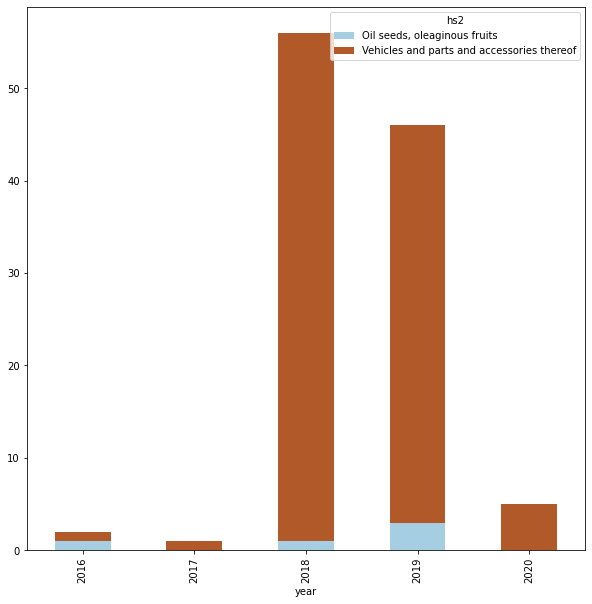

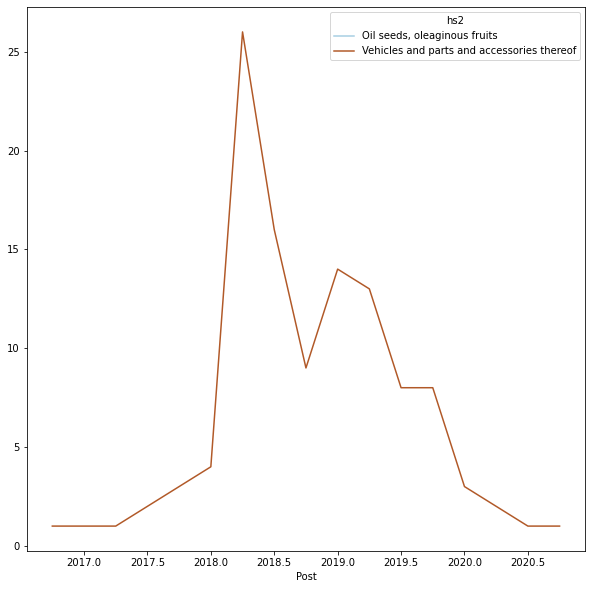

In [19]:
#绘制每一类hs2占总观测值的pie graph
df['hs2'].value_counts().plot.pie(figsize=(10,10),autopct='%.2f%%')
#绘制每年每一类hs2占总观测值的pie graph,把上面六个pie graph放在一起
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
df[df['year']=='2015']['hs2'].value_counts().plot.pie(ax=axes[0,0],autopct='%.2f%%')
df[df['year']=='2016']['hs2'].value_counts().plot.pie(ax=axes[0,1],autopct='%.2f%%')
df[df['year']=='2017']['hs2'].value_counts().plot.pie(ax=axes[0,2],autopct='%.2f%%')
df[df['year']=='2018']['hs2'].value_counts().plot.pie(ax=axes[1,0],autopct='%.2f%%')
df[df['year']=='2019']['hs2'].value_counts().plot.pie(ax=axes[1,1],autopct='%.2f%%')
df[df['year']=='2020']['hs2'].value_counts().plot.pie(ax=axes[1,2],autopct='%.2f%%')
#分年度绘制每一类hs2的bar graph
df.groupby('year')['hs2'].value_counts().unstack().plot(kind='bar',stacked=True,figsize=(10,10),colormap='Paired')
#分Post绘制每一类hs2变化的line graph
df.groupby('Post')['hs2'].value_counts().unstack().plot(kind='line',figsize=(10,10),colormap='Paired')